In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from copy import copy

Populating the interactive namespace from numpy and matplotlib


/home/tyamana/rep/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Этот ноутбук можно скачать тут: https://github.com/tyamana/imputer/tree/master/analysis

Файл с результатами, который используется в ноутбуке тут: https://github.com/tyamana/imputer/blob/master/analysis/results.txt

###Навигационная инструкция

Сначала будут всякие функции, некоторые технические, некоторые функциональные (если можно так сказать), их можно пропустить и не вникать, тем более что написаны они не очень читабельно на мой взгляд. Тем не менее я их снабдил превью на всякий случай.

###Функции

Чисто техническая функция сокращающая названия методов восстановления, чтобы они вмещались на диаграмму

In [2]:
def preproc_labels(labels):
    for index in range(len(labels)):
        if labels[index].startswith('knn+'):
            labels[index] = labels[index][4:]
        elif labels[index] == 'logistic_regr':
            labels[index] = 'log_reg'
        elif labels[index] == 'random_forest':
            labels[index] = 'rand_for'
    return labels

Функция возвращающая индекс элемента в массиве

In [3]:
def get_index_of_element_in_list(element, l):
    for index, value in enumerate(l):
        if value == element:
            return index
    return -1

In [4]:
def get_list_of_nth_values_from_dict_values(d, n):
    nth_values = []
    dict_values = d.values()
    for dict_value in dict_values:
        nth_values.append(dict_value[n])
    return nth_values

In [18]:
d = {'a':[1, 2], 'b':[3, 4]}
get_list_of_nth_values_from_dict_values(d, 1)

[2, 4]

Рисует диаграмму

In [6]:
def bar_chart(top_dict, ml_method):
    del top_dict['count']
    
    left_labels = preproc_labels(top_dict.keys())
    #height = top_dict.values()
    heights = get_list_of_nth_values_from_dict_values(top_dict, 0)
    qual_metrics = get_list_of_nth_values_from_dict_values(top_dict, 1)
    left = np.arange(len(left_labels))
    
    width = 0.25

    fig, ax = plt.subplots()
    fig.set_size_inches(15.0, 7.0)
    rects = ax.bar(left, heights, width, color=(0.2588,0.4433,1.0))

    ax.set_ylabel('Points')
    ax.set_title('Recover method for {0}'.format(ml_method))
    ax.set_xticks(left + width/2)
    ax.set_xticklabels(left_labels)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ind = int(rect.get_x())
            #print height, rect.get_x(), ind
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    ('%d' % int(height)) + (' %.3f' % round(qual_metrics[ind], 3)),
                    ha='center', va='bottom')

    autolabel(rects)
    
    if 'mean' in left_labels:
        #mean_value = top_dict['mean']
        mean_value = top_dict['mean'][0]
        mean_index = get_index_of_element_in_list('mean', left_labels)
        
        ax.get_children()[len(left_labels) - 1].set_color('r')
        x_border = int(rects[-1].get_x() + 1)
        plt.plot(np.arange(x_border), [mean_value]*x_border, 'r--')

    plt.show()

Парсит строку из файла с результатами эксперимента

In [5]:
def parse_results_line(line):
    """
    return: (flag, data), where flag is 'name' or result'
    """
    if '%' in line:
        
        raw_data = line.split(' ')
        
        info = {}
        
        info['dataset'] = raw_data[0][1:-1]
        info['X dim'] = raw_data[1][:-1]
        info['ml method'] = raw_data[2][:-1]
        info['nan rate'] = int(raw_data[3][:-4])
    
        return ('name', info)
    
    elif line.startswith('(0.'):
        
        raw_data = line.split(' ')
        
        info = {}
        
        info['acc or r2'] = float(raw_data[0][1:-1])
        info['method'] = raw_data[-1][:-1]
        
        return ('result', info)
    
    return False

def sort_and_print_top_dict(top):
    sorted_by_value = [(v, k) for (k, v) in top.iteritems()]
    sorted_by_value.sort(reverse=True)
    count = top['count']
    for v, k in sorted_by_value:
        if k != 'count':
            print float(v)/count, k
            
def sort_and_print_points(top):
    sorted_by_value = [(v, k) for (k, v) in top.iteritems()]
    sorted_by_value.sort(reverse=True)
    for v, k in sorted_by_value:
        if k != 'count':
            print v, k

Функция составляет словарь, в котором ключи - названия методов восстановления пропусков, а значения - количество попаданий в топ. Топ варьируется параметром - любое значение, топ который мы хотим вычислять (например, хотим смотреть кто попал в топ4 методов - выставляем параметр n = 4).

Если хотим в учитывать только сведения о результатах на данных с определенным количеством пропусков (5, 15, 30 или 50 , в проентах), то выбираем соответствующее rate. Хотим все - используем "-1"

Если хотим в учитывать только сведения о результатах работы определенным алгоритмом машинного обучения, выставляем соответствующее ml_method, хотим все - None.

Place_counter и should_progress - технические параметры

In [56]:
def get_top_n_dict_for_nan_rate(top_n, line, place_counter, n, rate, ml_method, should_process):
    """
    param n: the number of top places we want to account
    param rate: nan values percentage in data we want to account; if < 0 then we account all rates
    """
    parse_result = parse_results_line(line)

    if parse_result is not False:

        flag = parse_result[0]
        info = parse_result[1]

        if flag == 'name':
            place_counter = 1
            if (rate < 0 or info['nan rate'] == rate) and (ml_method is None or info['ml method'] == ml_method):
                should_process = True
            else:
                should_process = False

        if should_process is True and flag == 'result' and place_counter <= n:

            method = info['method']

            if method in top_n.keys():
                top_n[method] += 1
            else:
                top_n[method] = 1

            top_n['count'] += 1
            place_counter += 1
            
    return (top_n, place_counter, should_process)

То же самое, только вместо количества попаданий в топ - другая метрика.
Используемая метрика - количество очков, которое понижается, если алгоритм попал на более низкое место в топе.

In [7]:
def get_top_n_dict_rate_with_points(top_n, line, place_counter, n, rate, ml_method, should_process, 
                                    last_updated_methods):
    """
    param n: the number of top places we want to account
    param rate: nan values percentage in data we want to account; if < 0 then we account all rates
    param ml_method: machine learning method we want to get statistics for; if None than all methods are acceptable
    """
    parse_result = parse_results_line(line)

    if parse_result is not False:

        flag = parse_result[0]
        info = parse_result[1]

        if flag == 'name':
            place_counter = 1
            last_updated_methods = []
            if (rate < 0 or info['nan rate'] == rate) and (ml_method is None or info['ml method'] == ml_method):
                should_process = True
            else:
                should_process = False

        if should_process is True and flag == 'result':
            
            if place_counter <= n:
                method = info['method']
                points_to_add = n - place_counter + 1
                acc_or_r2 = info['acc or r2']

                if method in top_n.keys():
                    top_n[method][0] += points_to_add
                    top_n[method][2] = acc_or_r2
                else:
                    top_n[method] = [points_to_add, 0.0, acc_or_r2]

                top_n['count'] += 1
                last_updated_methods.append(method)
                
            elif place_counter == n + 1:
                for method in last_updated_methods:
                    #таким образом теперь метрика считается относительно метрики топ-4
                    top_n[method][1] += top_n[method][2] - info['acc or r2']
                    
            place_counter += 1
            
    return (top_n, place_counter, should_process, last_updated_methods)

###Основной код

Открываем файл с результатами и начинаем его обрабатывать.

На выходе получаем словарь топа.

In [8]:
def processing(top_n, rate, ml_meth):
    f = open('/home/tyamana/missing_values/results.txt', 'r')

    regression_processing = False
    classification_processing = False
    class_top1 = {'count': 0}
    place_counter = 1
    should_process = False
    last_updated_methods = []

    for line in f:
        if 'Classification' in line:
            classification_processing = True

        if classification_processing is True:
            class_top1, place_counter, should_process, last_updated_methods = get_top_n_dict_rate_with_points(class_top1, 
                                                                                        line, 
                                                                                        place_counter, 
                                                                                        top_n, rate,
                                                                                        ml_meth,
                                                                                        should_process,
                                                                                        last_updated_methods)
            """                                                                         
            class_top1, place_counter, should_process = get_top_n_dict_for_nan_rate(class_top1, 
                                                                                    line, 
                                                                                    place_counter, 
                                                                                    3, -1,
                                                                                    'log_reg',
                                                                                    should_process)
            """

        if 'Regression' in line:
            classification_processing = False
            regression_processing = True

        if regression_processing is True:
            pass
            """
            class_top1, place_counter, should_process = get_top_n_dict_rate_with_points(class_top1, 
                                                                                        line, 
                                                                                        place_counter, 
                                                                                        3, 50,
                                                                                        'gb',
                                                                                        should_process)
            """
    f.close()
    return class_top1

Дальше идут диаграммы с примененной функцией рисования к различным словарям с топами. В качестве метрики используется функция с присуждением очков за различное место в топе.

Они идут в порядке обратном тому, как я их выполнял, поэтому возможно будет прослежена некая непоследовательность в действиях (а может и не будет)

Везде берется топ3 и для него вычислется метрика.

Комментарий про метрику: за топ1 - 3 очка, за топ2 - 2, за топ3 - 1.

###Задача классификации, все алгоритмы для различных процентов пропусков

При решении задачи классификации с 50% пропусков (часто ли это бывает?), рэндом форест, кнн и бустинг работают лучше всего. Спойлер: это вообще лучшие методы в исследовании.

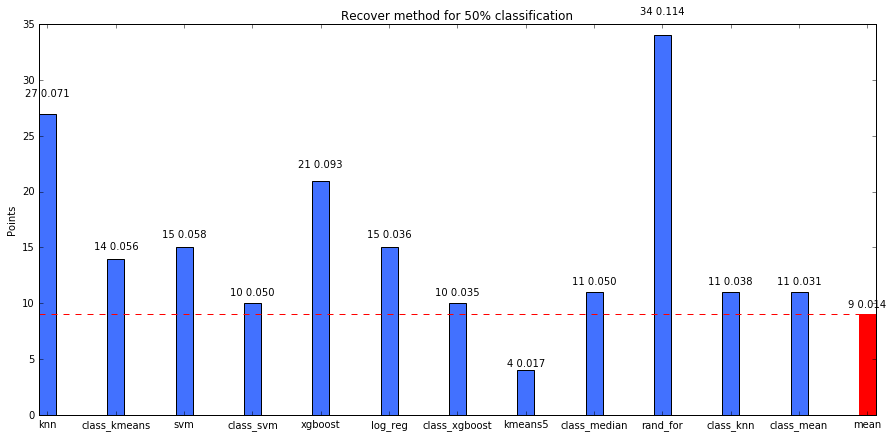

In [76]:
class_top1 = processing(3, 50, None)
bar_chart(copy(class_top1), '50% classification')

Для 30% кнн, рф, бустинг и бустинг по классу.

О, самое время рассказать, что я решил с классовыми методами. Я просто требую от юзера любой оценки для значений классов. В эксперименте этой оценкой всегда был результат работы алгоритма кнн на тестовых данных.

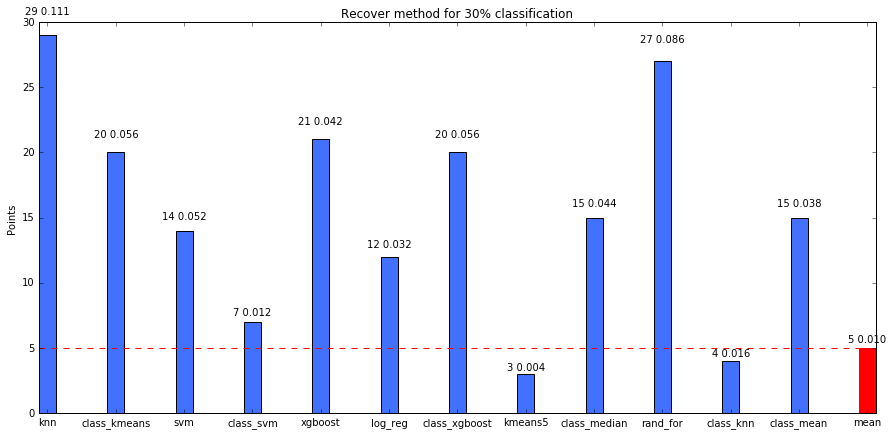

In [75]:
class_top1 = processing(3, 30, None)
bar_chart(copy(class_top1), '30% classification')

Тут уже нет явного лидера, но внезапно самым хорошим оказался классовый кнн.

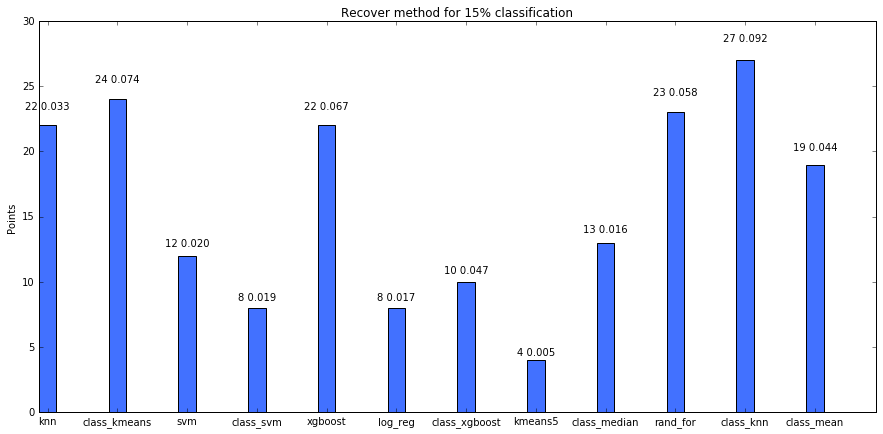

In [77]:
class_top1 = processing(3, 15, None)
bar_chart(copy(class_top1), '15% classification')

5%, бустинг логистическая оегрессия и рэндом форест

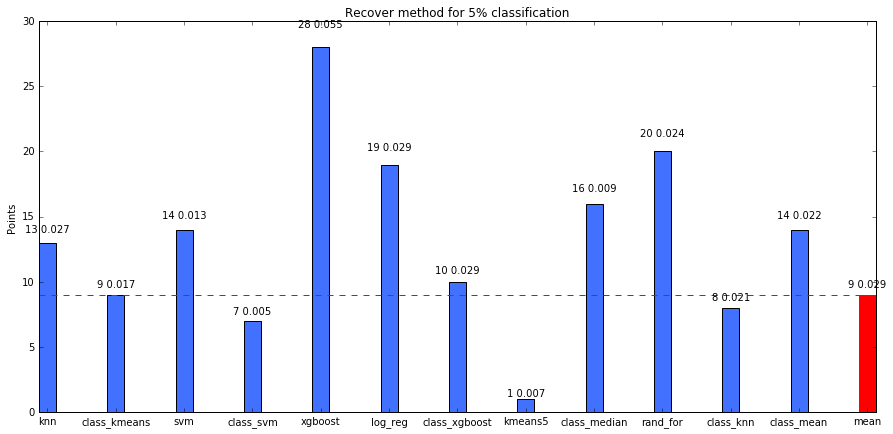

In [78]:
class_top1 = processing(3, 5, None)
bar_chart(copy(class_top1), '5% classification')

###Для задачи регрессии

5%, knn, xgboost, random forest почти на равне, как увидим позже из этой троицы кое-кто выпадет.

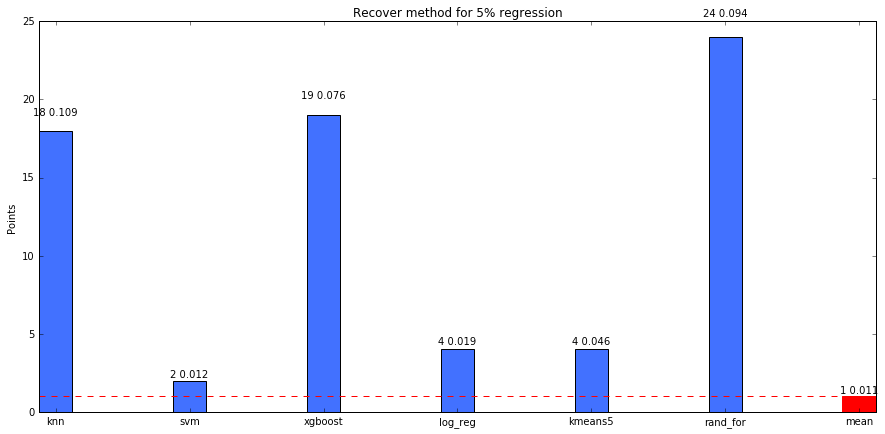

In [81]:
class_top1 = processing(3, 5, None)
bar_chart(copy(class_top1), '5% regression')

Для регрессии в целом - бустинг и случайный лес лучшие алгоритмы, в целом от этой концепции почти никто не отбивается.

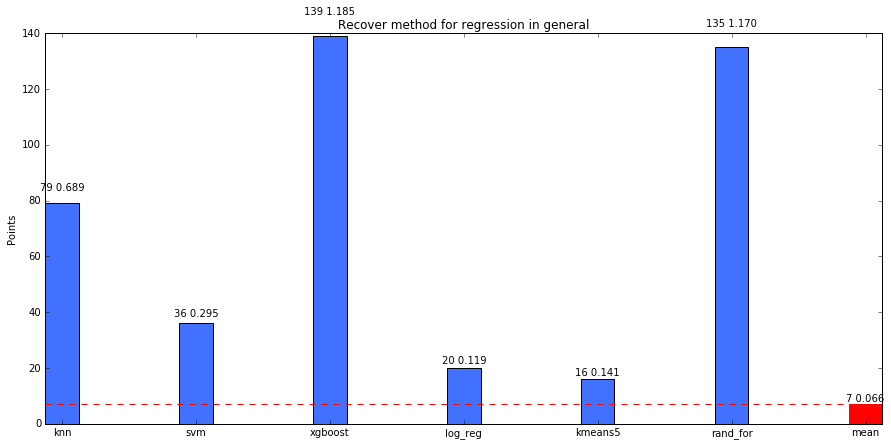

In [82]:
class_top1 = processing(3, -1, None)
bar_chart(copy(class_top1), 'regression in general')

Дальше для разных методов рещения задачи регрессии

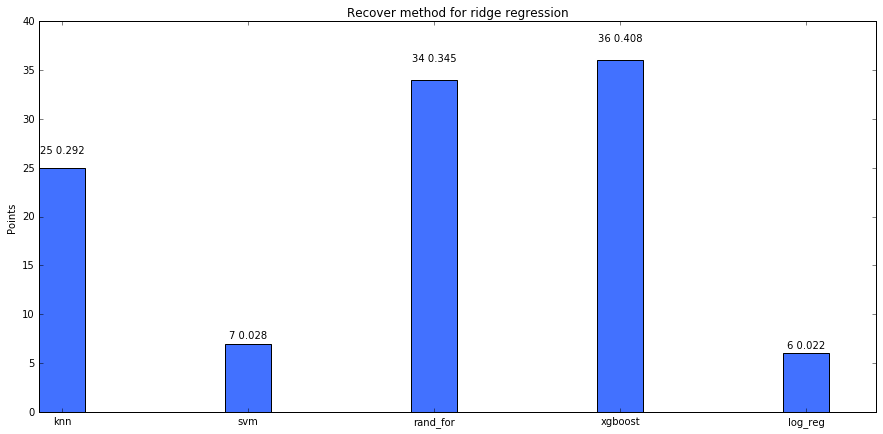

In [83]:
class_top1 = processing(3, -1, 'ridge')
bar_chart(copy(class_top1), 'ridge regression')

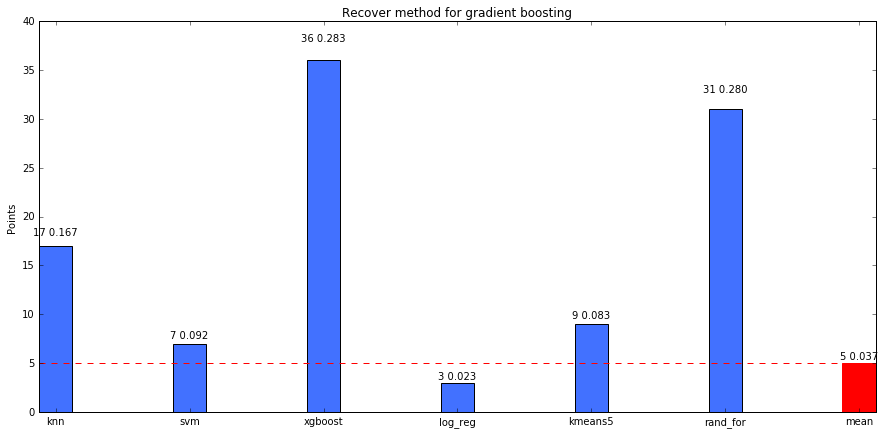

In [84]:
class_top1 = processing(3, -1, 'gb')
bar_chart(copy(class_top1), 'gradient boosting')

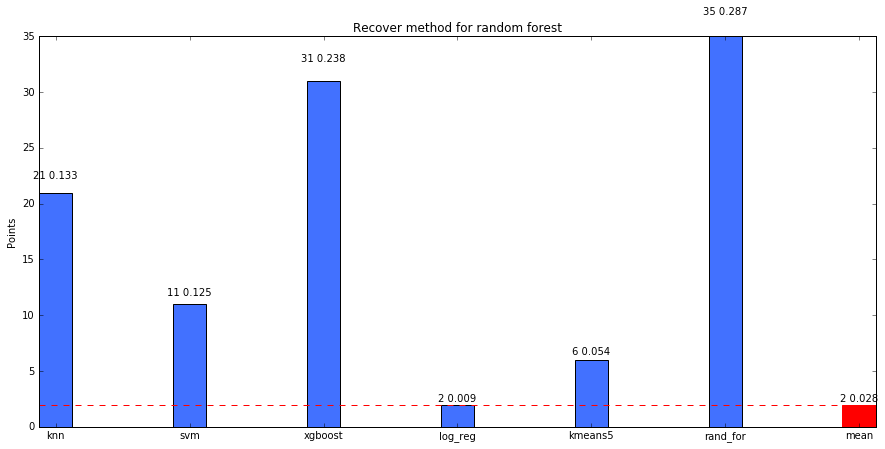

In [85]:
class_top1 = processing(3, -1, 'rf')
bar_chart(copy(class_top1), 'random forest')

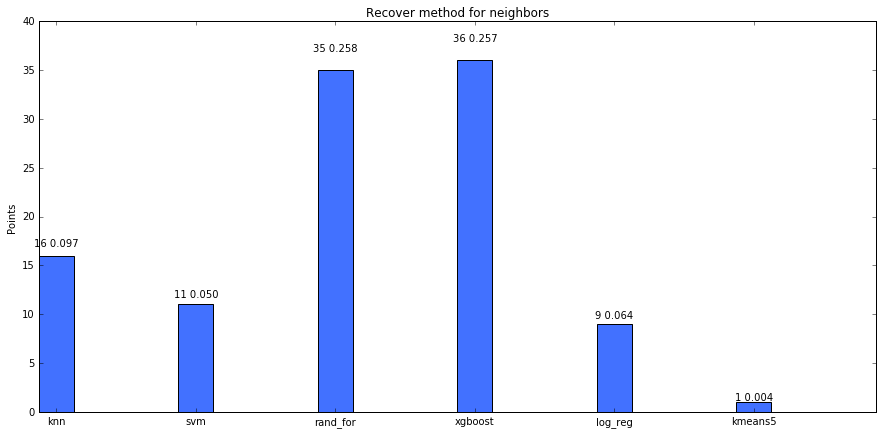

In [86]:
class_top1 = processing(3, -1, 'neigh')
bar_chart(copy(class_top1), 'neighbors')

Так что с регрессией в целом все ясно - случайный лес и бустинг не оставляют шансов. Тестировал на различных перцентажах пропусков - та же картина.

###Задача классификации, результаты для разных алгоритмов мо

Тут интереснее.

Хотя вот для случайного леса все обычно, только в компанию добавился svm

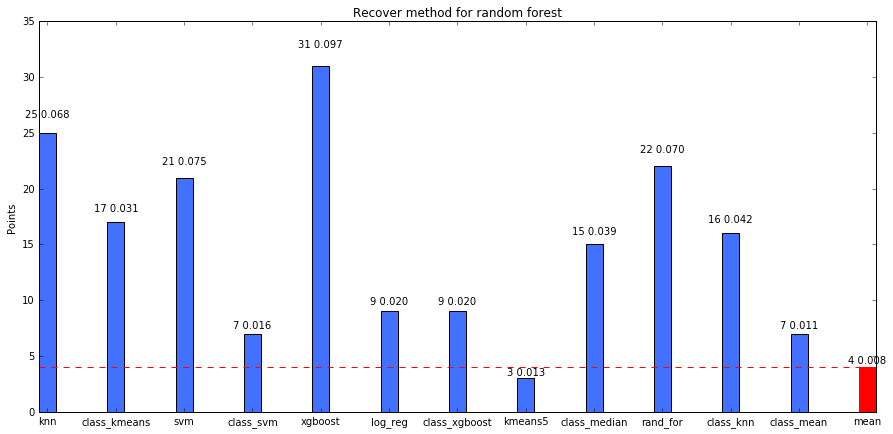

In [88]:
class_top1 = processing(3, -1, 'rf')
bar_chart(copy(class_top1), 'random forest')

Для соседей - лучший классовой среднее, вдобавок все те же рф, б и классовый kmeans

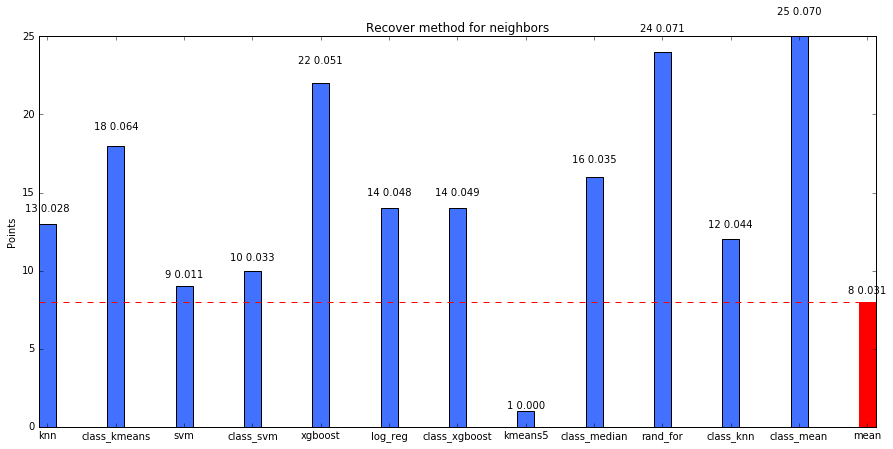

In [93]:
class_top1 = processing(3, -1, 'neighbors')
bar_chart(copy(class_top1), 'neighbors')

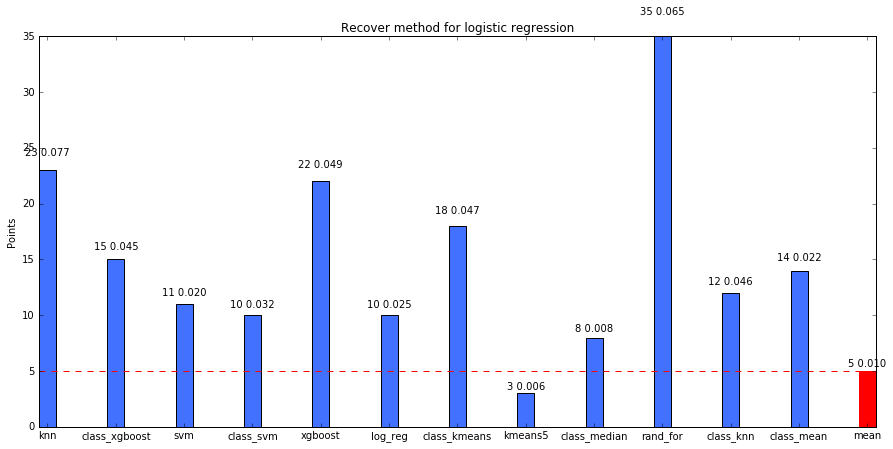

In [94]:
class_top1 = processing(3, -1, 'log_reg')
bar_chart(copy(class_top1), 'logistic regression')

Для svm хорошо себя показали алгоритмы логистич регрессии и рф, лучший кнн.

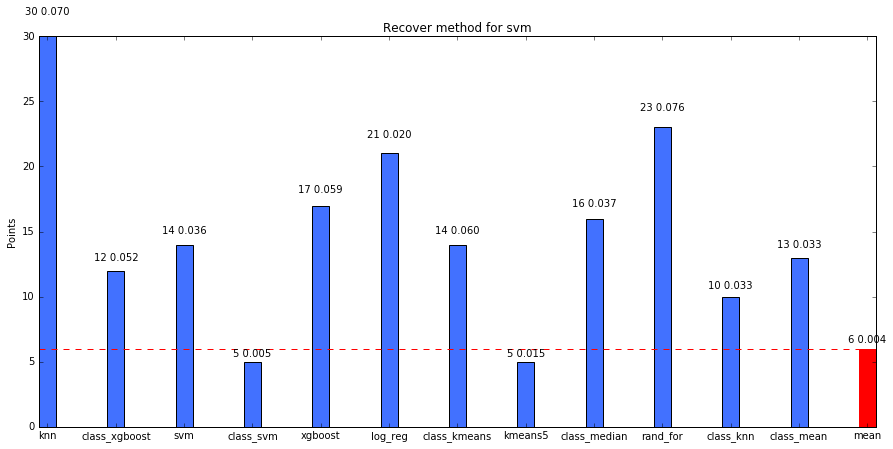

In [95]:
class_top1 = processing(3, -1, 'svm')
bar_chart(copy(class_top1), 'svm')

Дальше смотреть не нужно - там черновая обработка результатов.
В пятницу буду еще тестировать на классификации с различным количеством пропусков и различные методы. А пока - так.

Пятничное обновление:
Посмотрим, что покажут результаты для в отдельности каждого процента пропусков и алгоритма, решающего задачу.
Пройдемся по ним и нарисуем бар чарт. (надо бы как-то их вытащить, чтобы можно было по-нормальному смотреть)

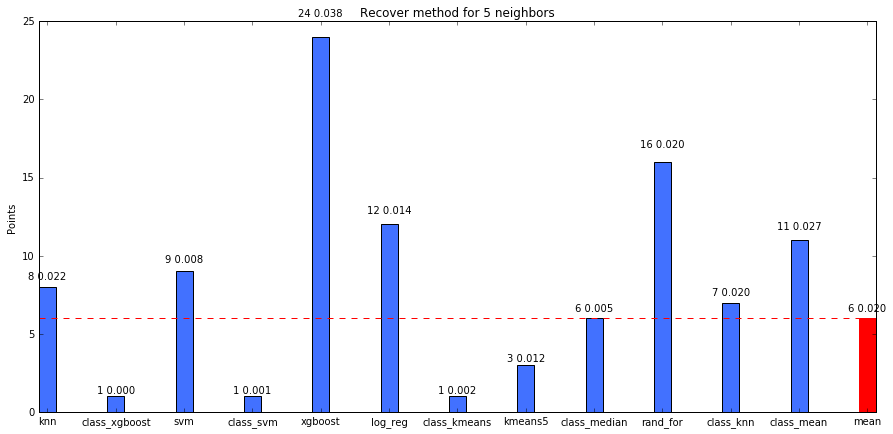

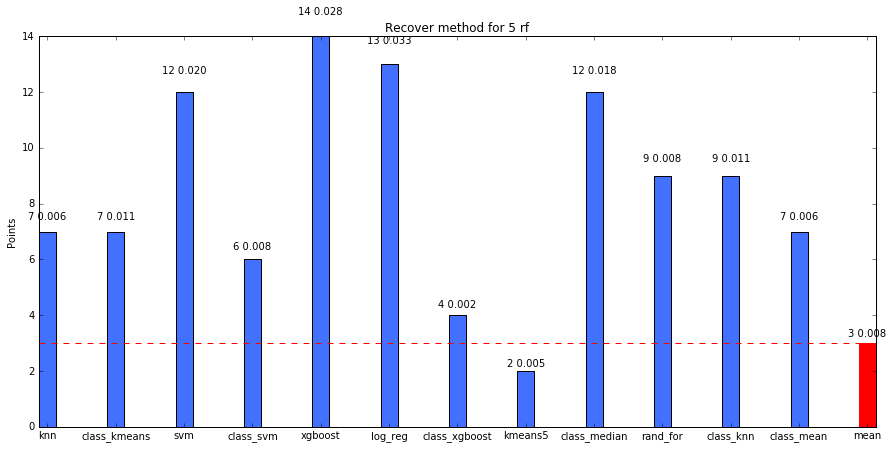

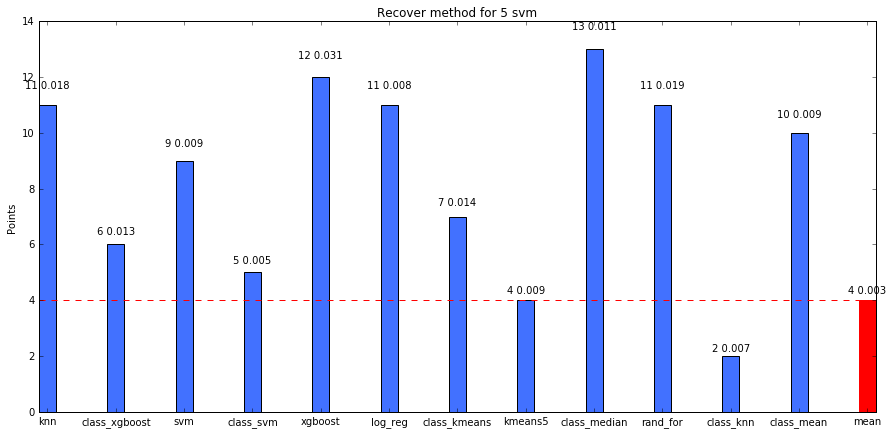

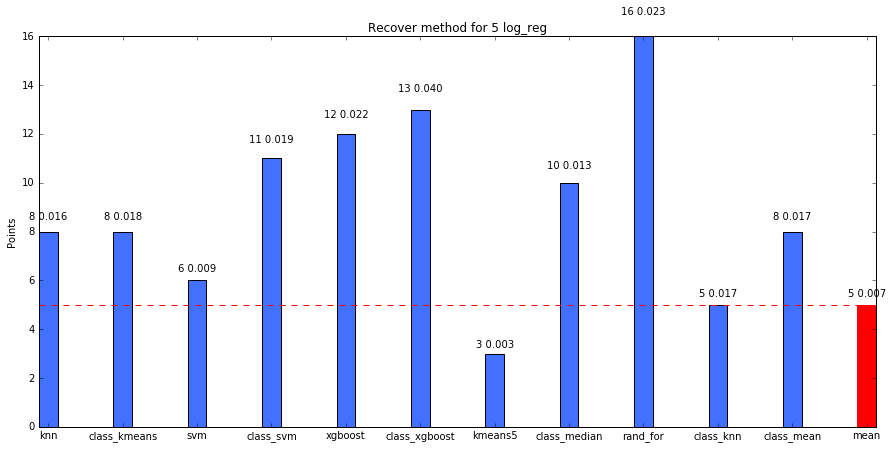

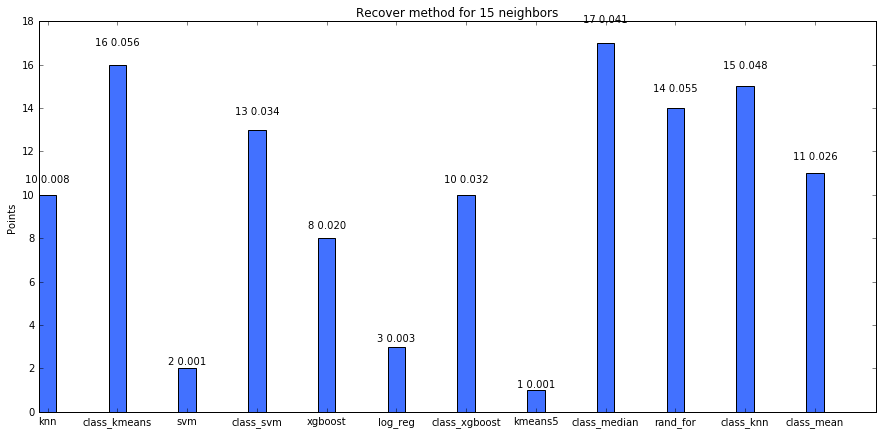

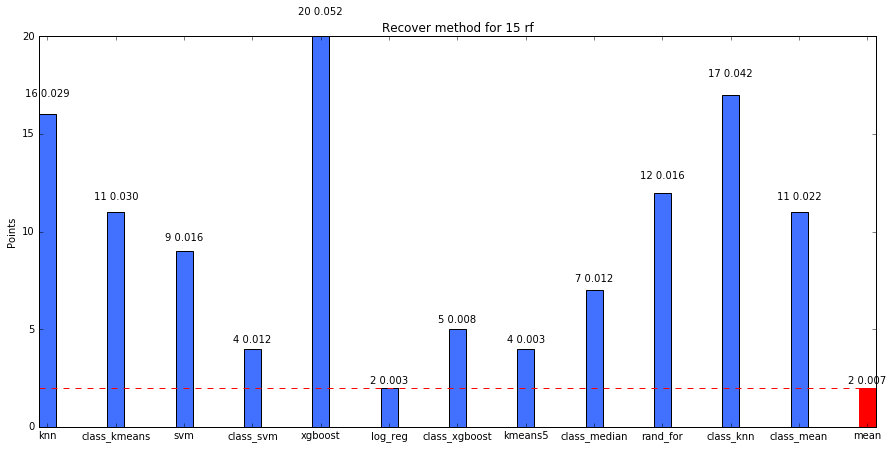

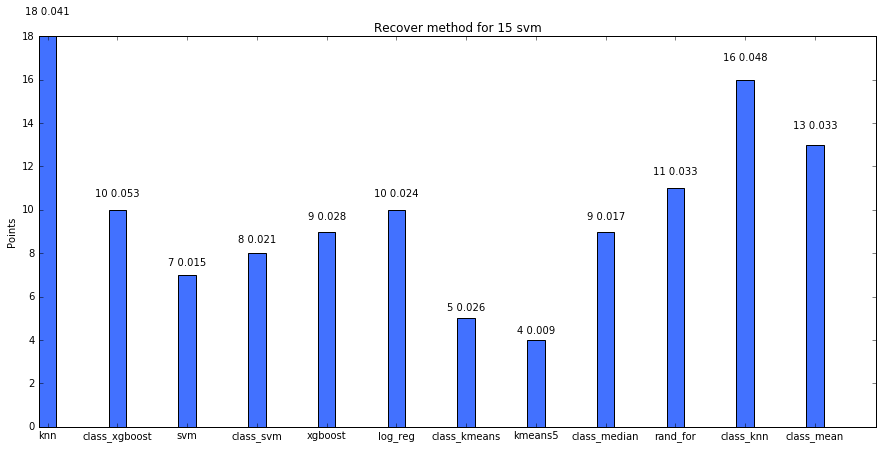

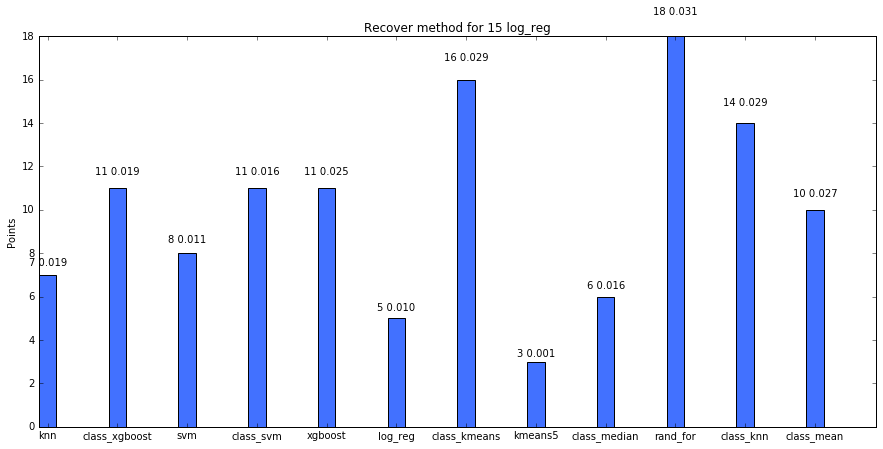

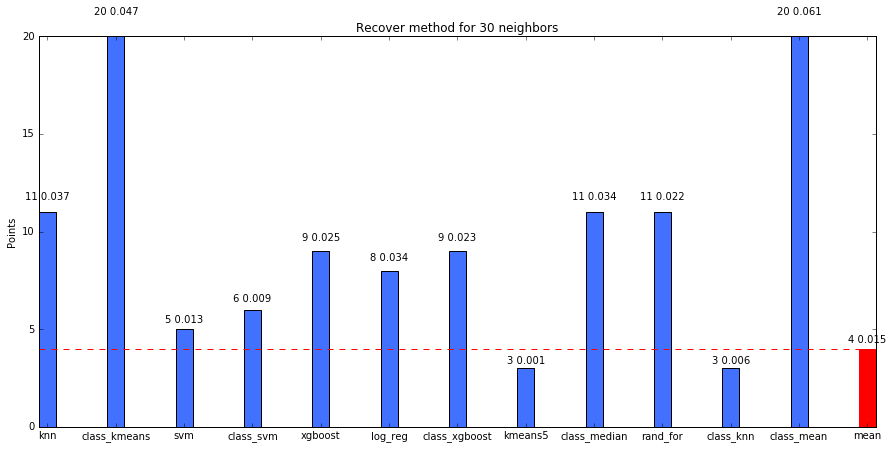

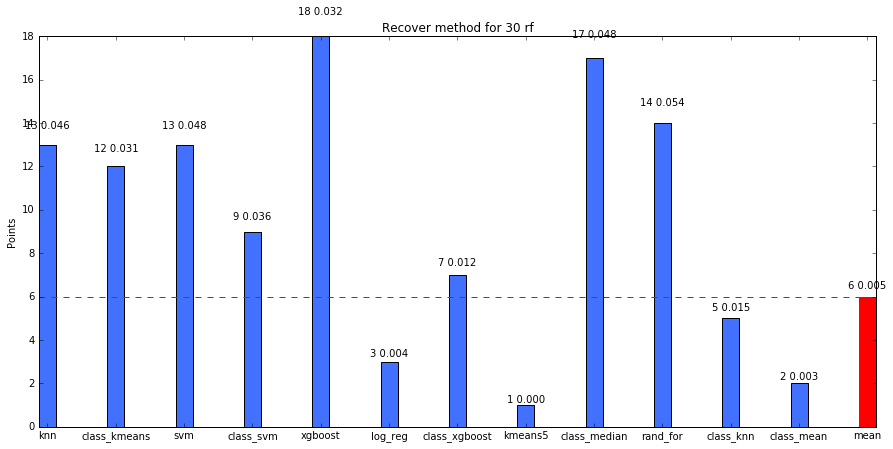

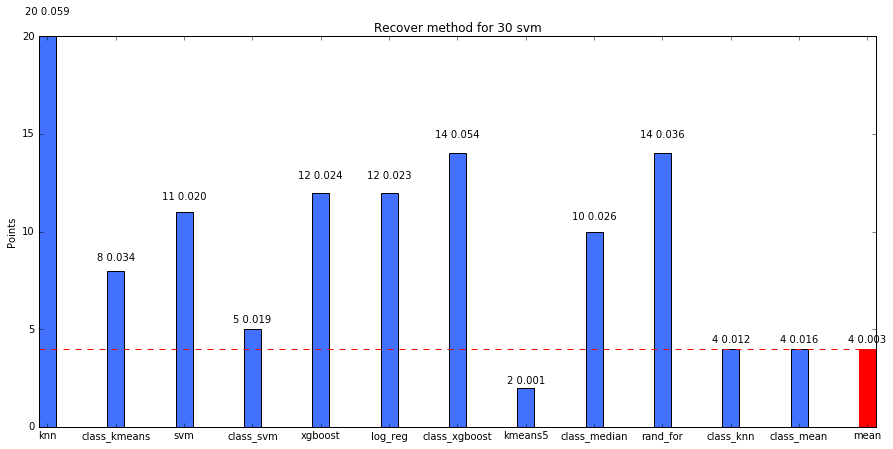

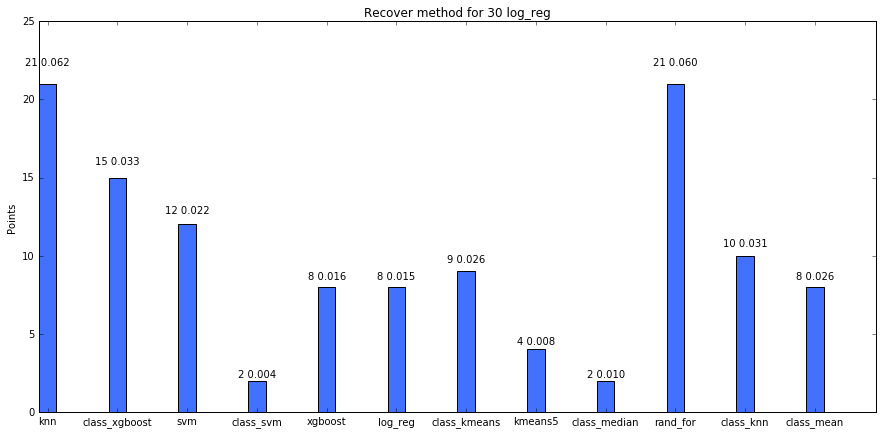

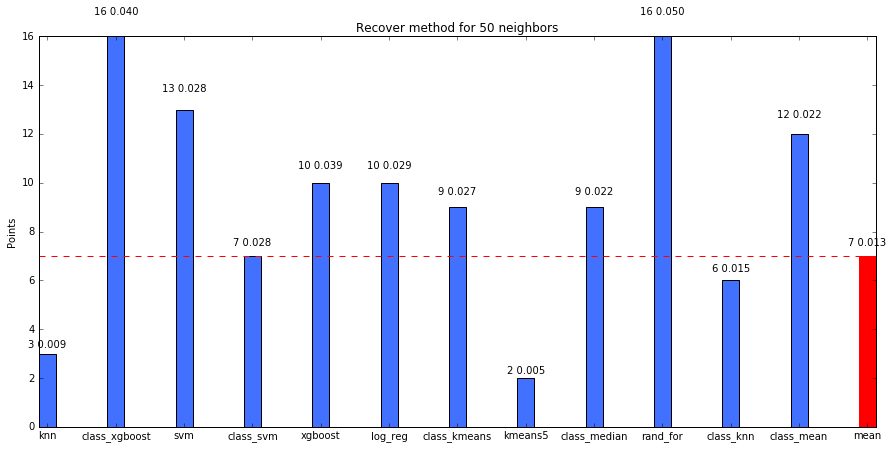

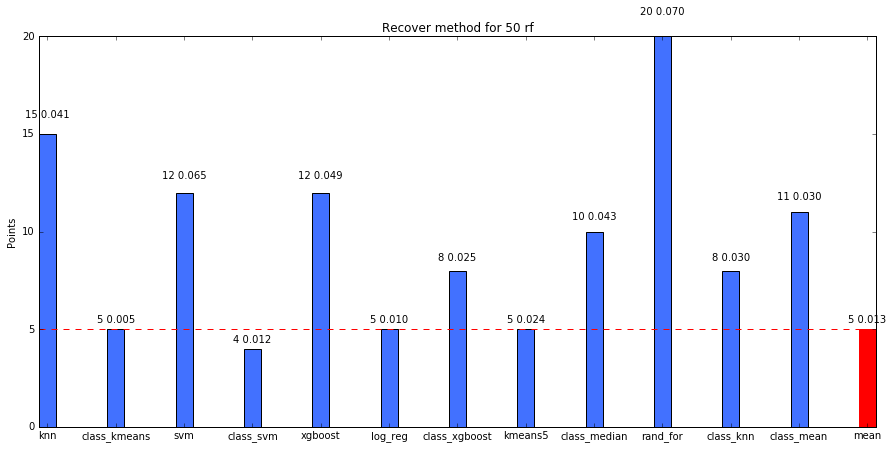

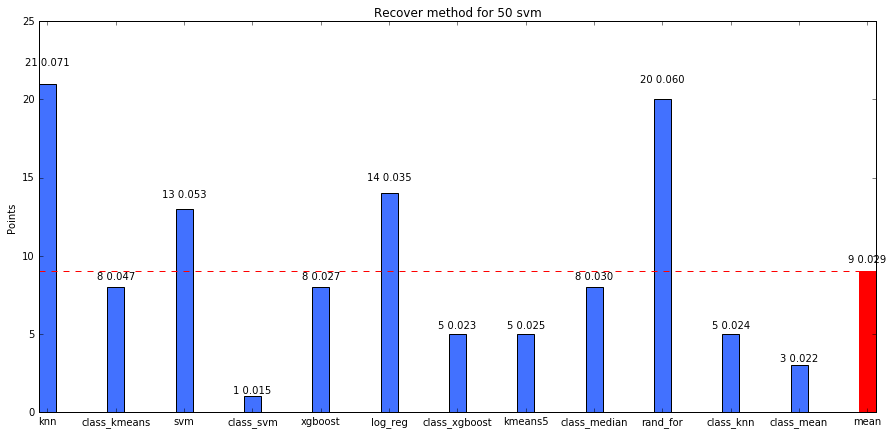

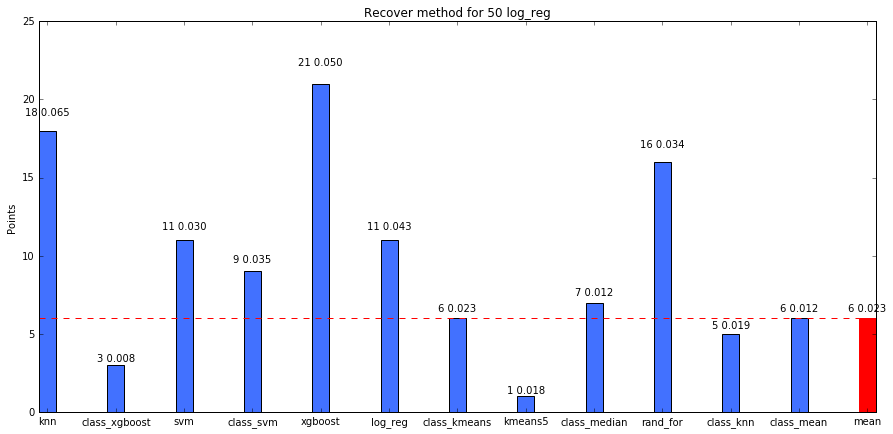

In [96]:
rates = [5, 15, 30, 50]
ml_methods = ['neighbors', 'rf', 'svm', 'log_reg']

for rate in rates:
    for ml_meth in ml_methods:
        top_dict = processing(5, rate, ml_meth)
        bar_chart(copy(top_dict), '{0} {1}'.format(rate, ml_meth))

Тут есть интересные результаты, в некоторых случаях хороший результат дают довольно неожиданные методы.

Думаю еще построить графики, которые буду показывать преимущество методов над mean по параметру качества.

In [3]:
def get_score_for_comparison(mean_acc, comparing_acc, comparing_method, line, rate, ml_meth, should_process):
    """
    param rate: nan values percentage in data we want to account; if < 0 then we account all rates
    """
    parse_result = parse_results_line(line)

    if parse_result is not False:

        flag = parse_result[0]
        info = parse_result[1]

        if flag == 'name':
            if (rate < 0 or info['nan rate'] == rate) and (ml_meth is None or info['ml method'] == ml_meth):
                if len(mean_acc) != len(comparing_acc):
                    mean_acc.pop()
                    print '+'
                should_process = True
            else:
                should_process = False

        if should_process is True and flag == 'result':

            method = info['method']
            score = info['acc or r2']
            
            if method == 'mean':
                mean_acc.append(score)
            elif method == comparing_method:
                comparing_acc.append(score)
            
    return (mean_acc, comparing_acc, should_process)

In [4]:
def score_processing(comparing_meth, rate, ml_meth):
    f = open('/home/tyamana/missing_values/results.txt', 'r')

    regression_processing = False
    classification_processing = False
    mean_acc = []
    comparing_acc = []
    should_process = False

    for line in f:
        if 'Classification' in line:
            classification_processing = True

        if classification_processing is True:

            mean_acc, comparing_acc, should_process = get_score_for_comparison(mean_acc,
                                                                               comparing_acc,
                                                                               comparing_meth,
                                                                               line,
                                                                               rate,
                                                                               ml_meth,
                                                                               should_process)
            

        if 'Regression' in line:
            classification_processing = False
            regression_processing = True

        if regression_processing is True:
            pass
            """
            mean_acc, comparing_acc, should_process = get_score_for_comparison(mean_acc,
                                                                               comparing_acc,
                                                                               comparing_meth,
                                                                               line,
                                                                               rate,
                                                                               ml_meth,
                                                                               should_process)
            """
    
    f.close()
    return (mean_acc, comparing_acc)

In [142]:
method_names = ['xgboost', 'knn', 'svm', 'random_forest', 'kmeans5', 'knn+class_xgboost', 'knn+class_knn',
                'logistic_regr', 'knn+class_svm', 'knn+class_mean', 'mean', 'knn+class_median', 'knn+class_kmeans']

In [5]:
def difference(l1, l2):
    diff = [0]*len(l1)
    for i in range(len(l1)):
        diff[i] = l1[i] - l2[i]
    return diff    

In [24]:
a = [2.28, 3.22]
b = [3.28, 0.22]
d = difference(a, b)

In [25]:
sum(d)

2.0

In [7]:
def acc_graph(recovery_method):
    plt.figure().set_size_inches(16.5, 30.0)
    plot_number = 1

    for rate in rates:
        for ml_method in ml_methods:
            mean_acc, comparing_acc = score_processing(recovery_method, rate, ml_method)
            
            t = np.arange(len(mean_acc))

            plt.subplot(8, 2, plot_number)
            plt.plot(t, mean_acc, 'r--', t, comparing_acc, 'b-.')
            plt.yscale('linear')
            plt.ylabel('Accuracy')
            if recovery_method != 'xgboost' and recovery_method != 'random_forest':
                meth_name = recovery_method[4:]
            else:
                meth_name = recovery_method
            plt.legend(('mean', meth_name), loc='upper left', fontsize='medium')
            accuracy_advantage = sum(difference(comparing_acc, mean_acc))
            plt.title('{0} {1}'.format(rate, ml_method) + ', acc_advantage: %.3f' % round(accuracy_advantage, 3))
            plt.grid(True)
            plot_number += 1

Update днем пятницы:
Графики accuracy для классовых методов и "хороших" xgboost и random forest

In [8]:
rates = [5, 15, 30, 50]
ml_methods = ['neighbors', 'rf', 'log_reg', 'svm']

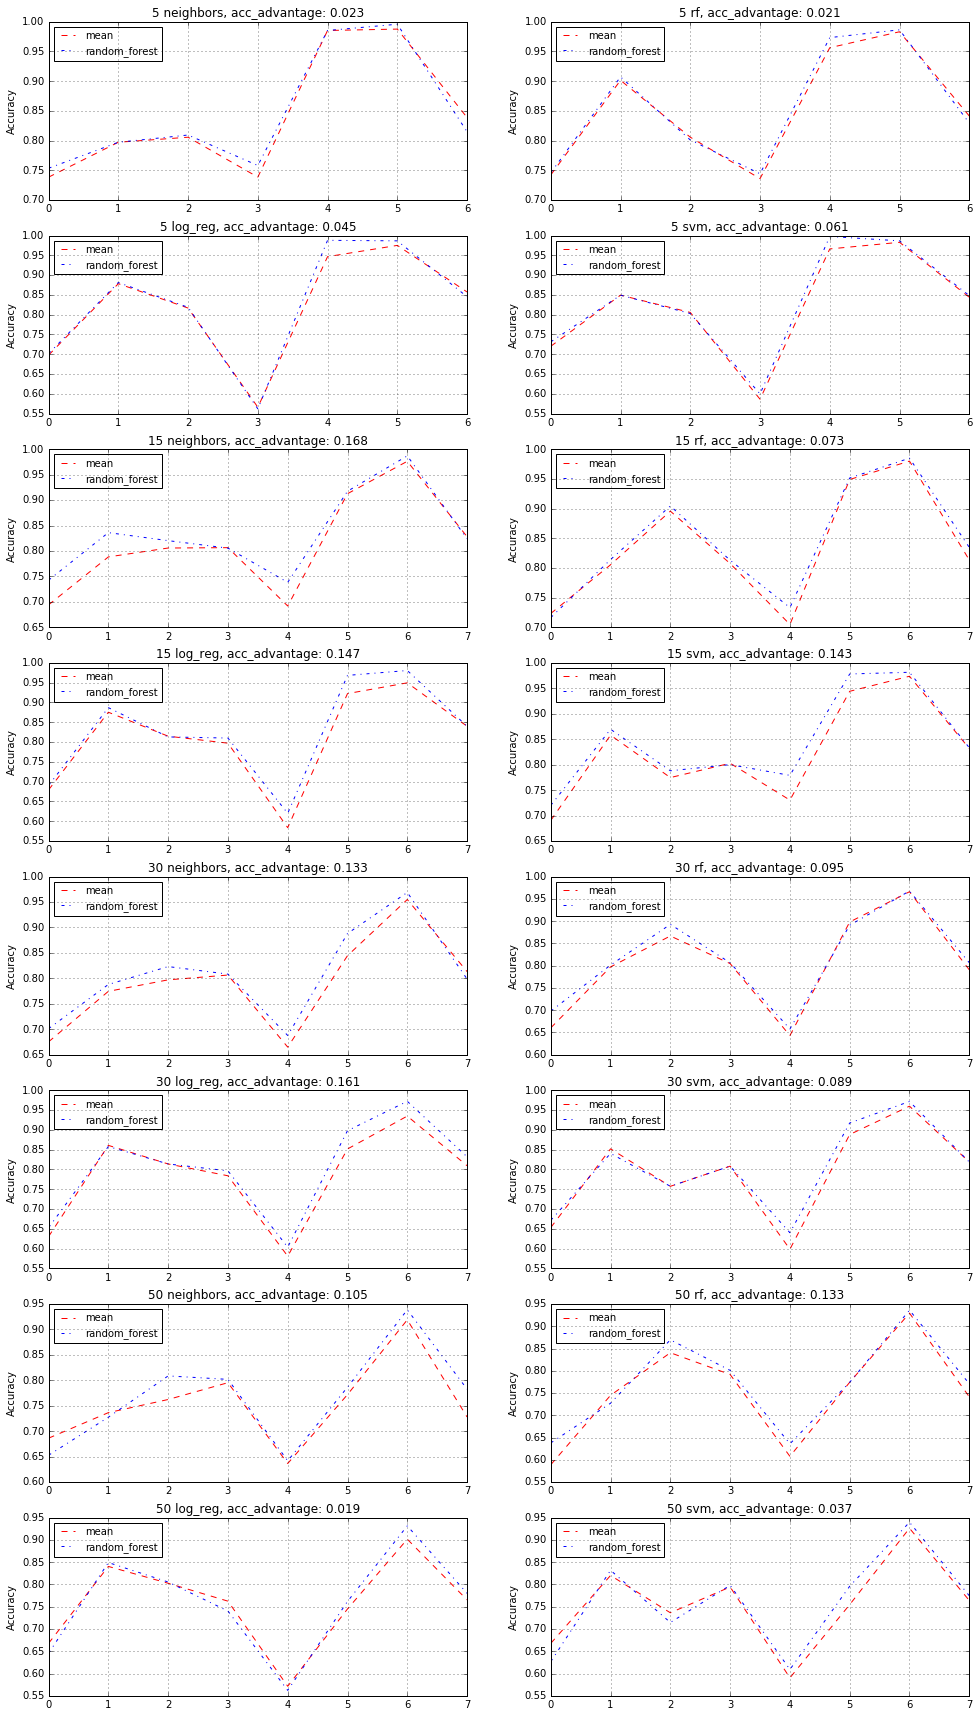

In [9]:
acc_graph('random_forest')

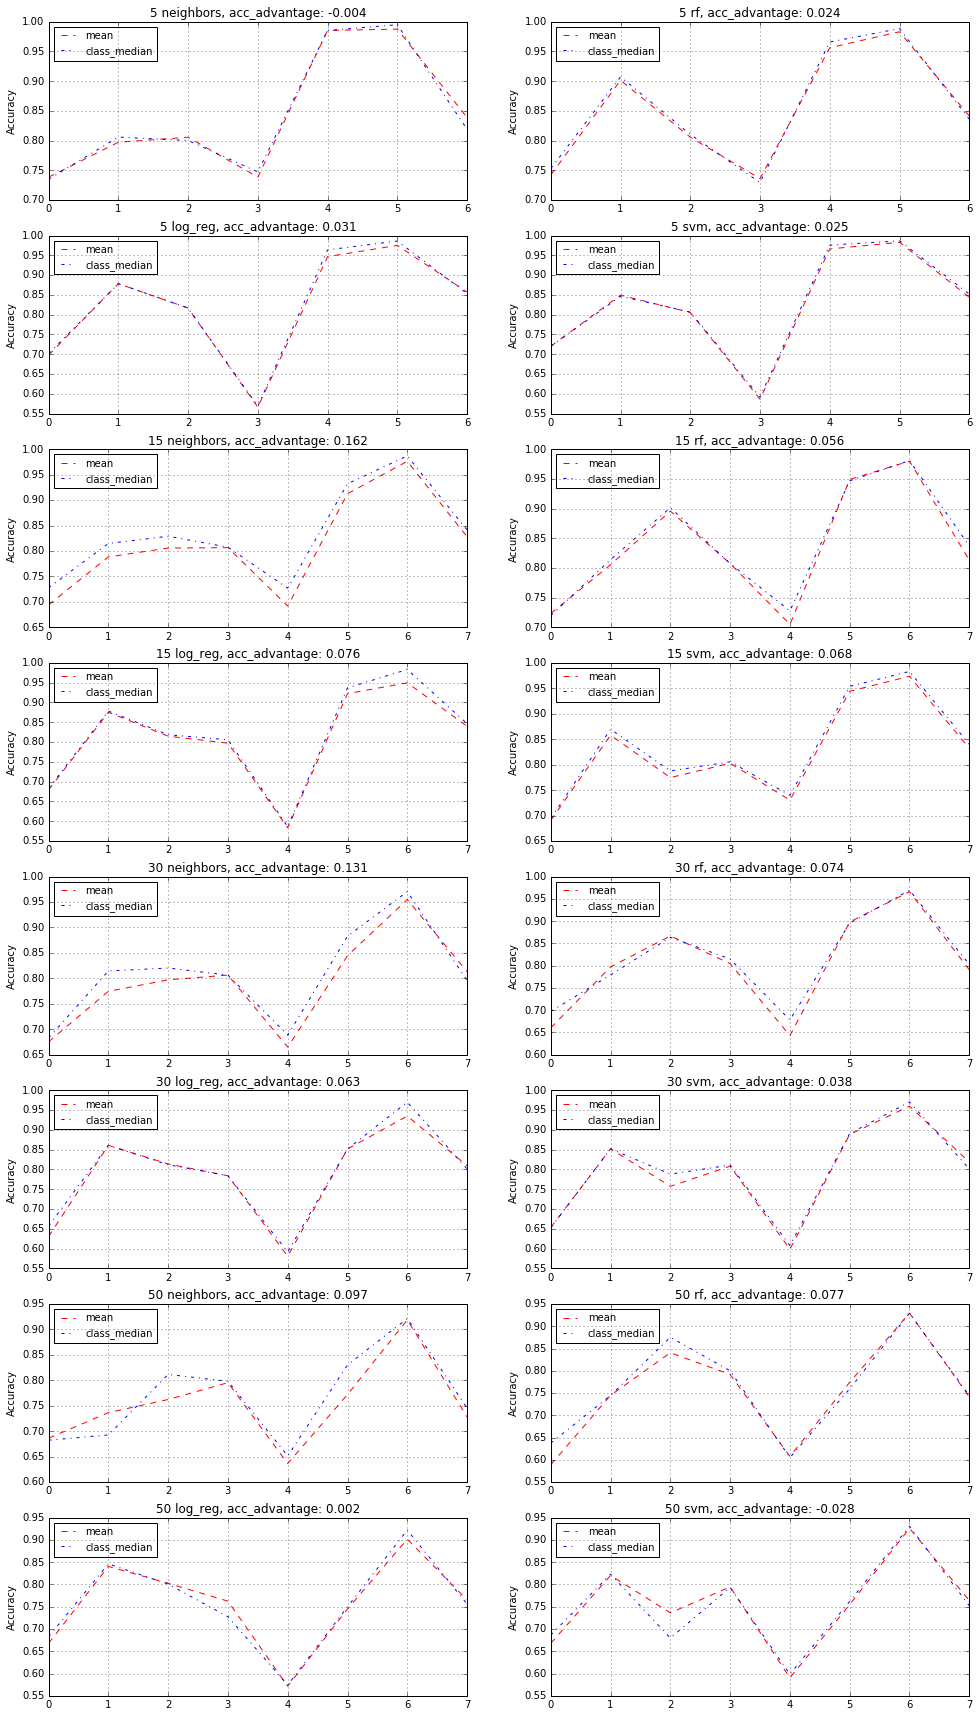

In [10]:
acc_graph('knn+class_median')

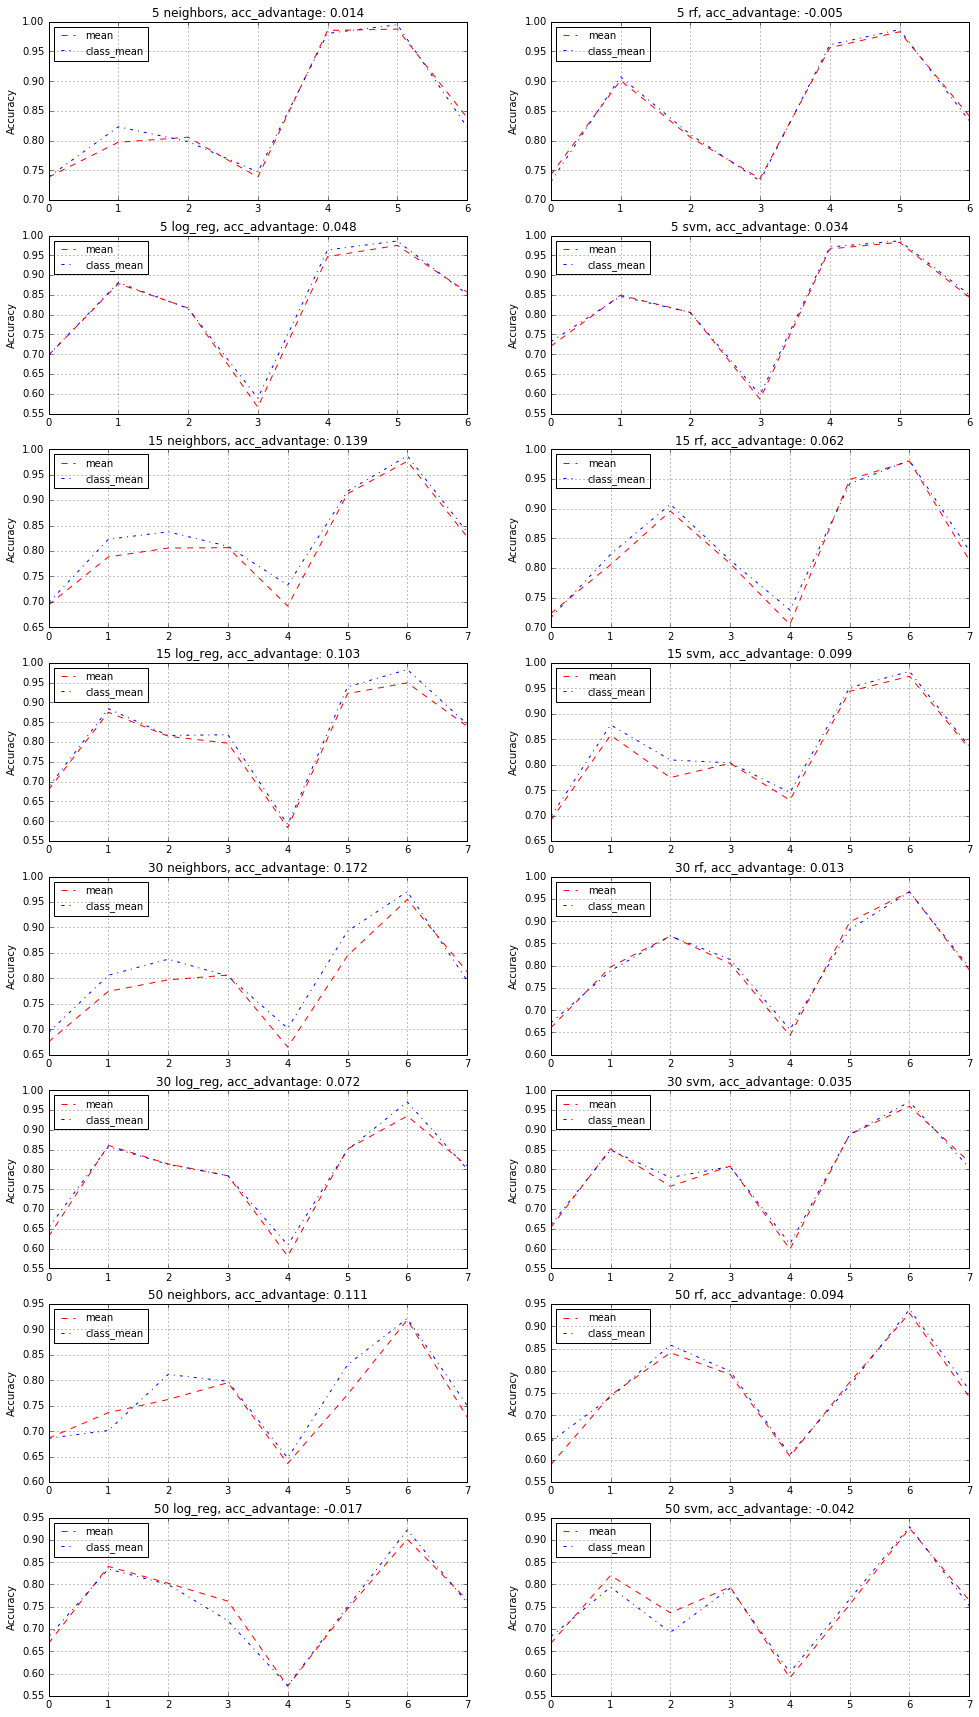

In [11]:
acc_graph('knn+class_mean')

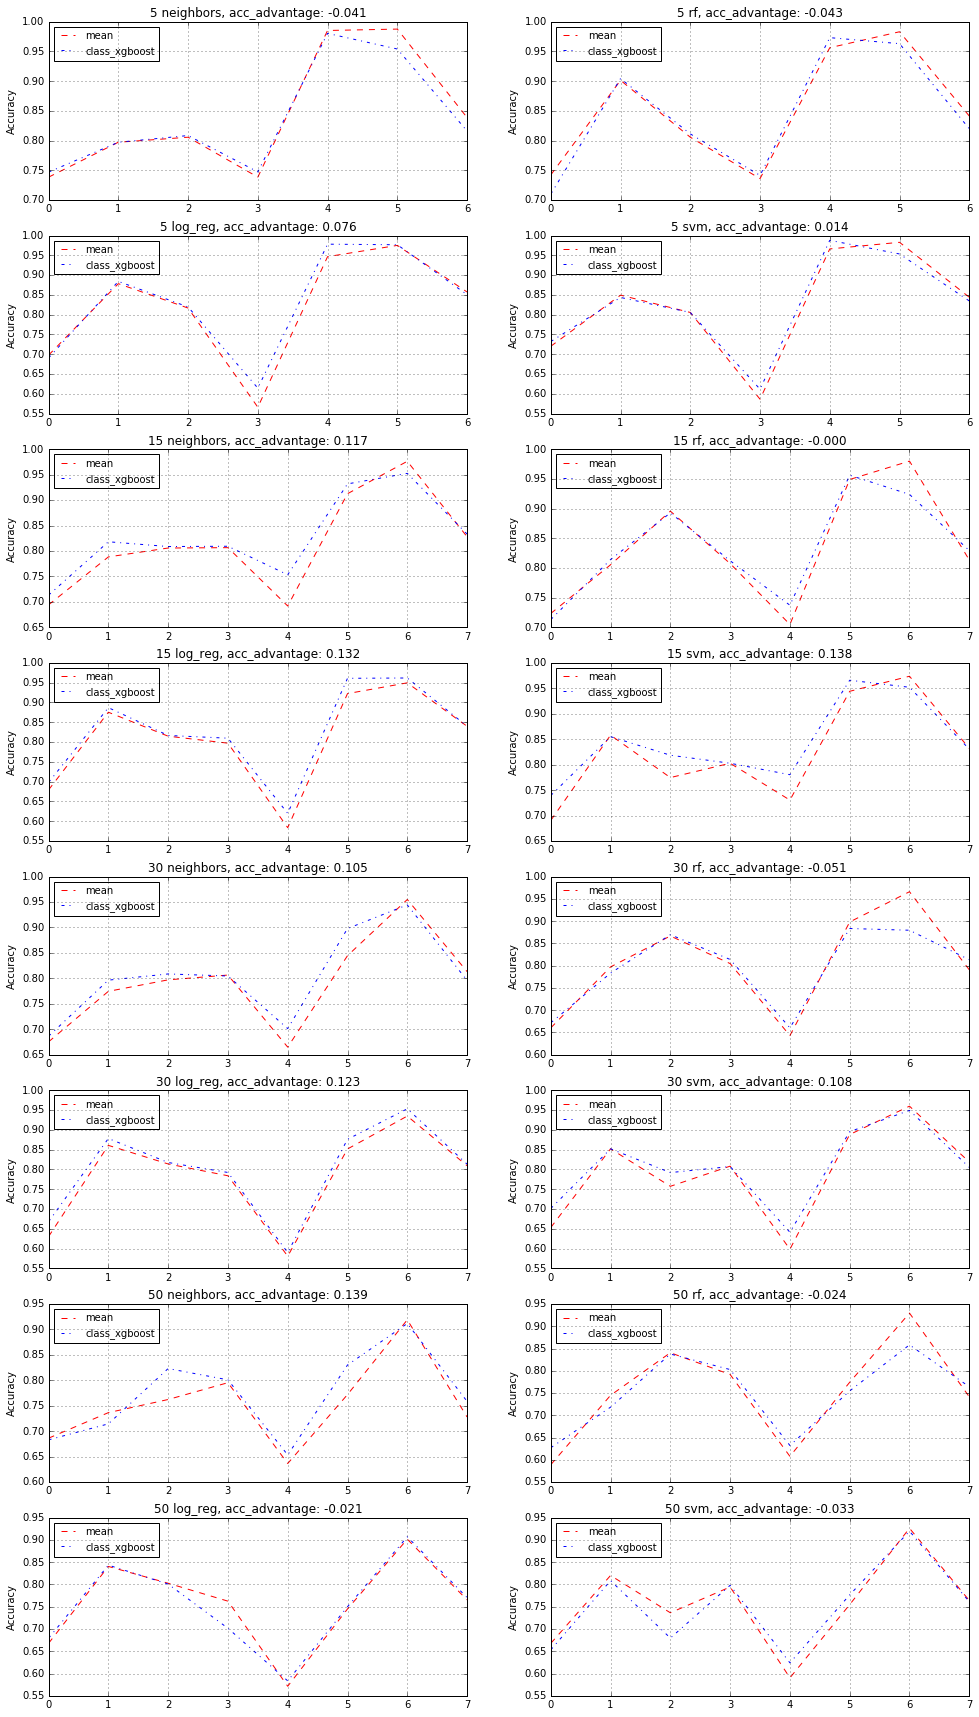

In [12]:
acc_graph('knn+class_xgboost')

+
+
+
+
+
+
+
+


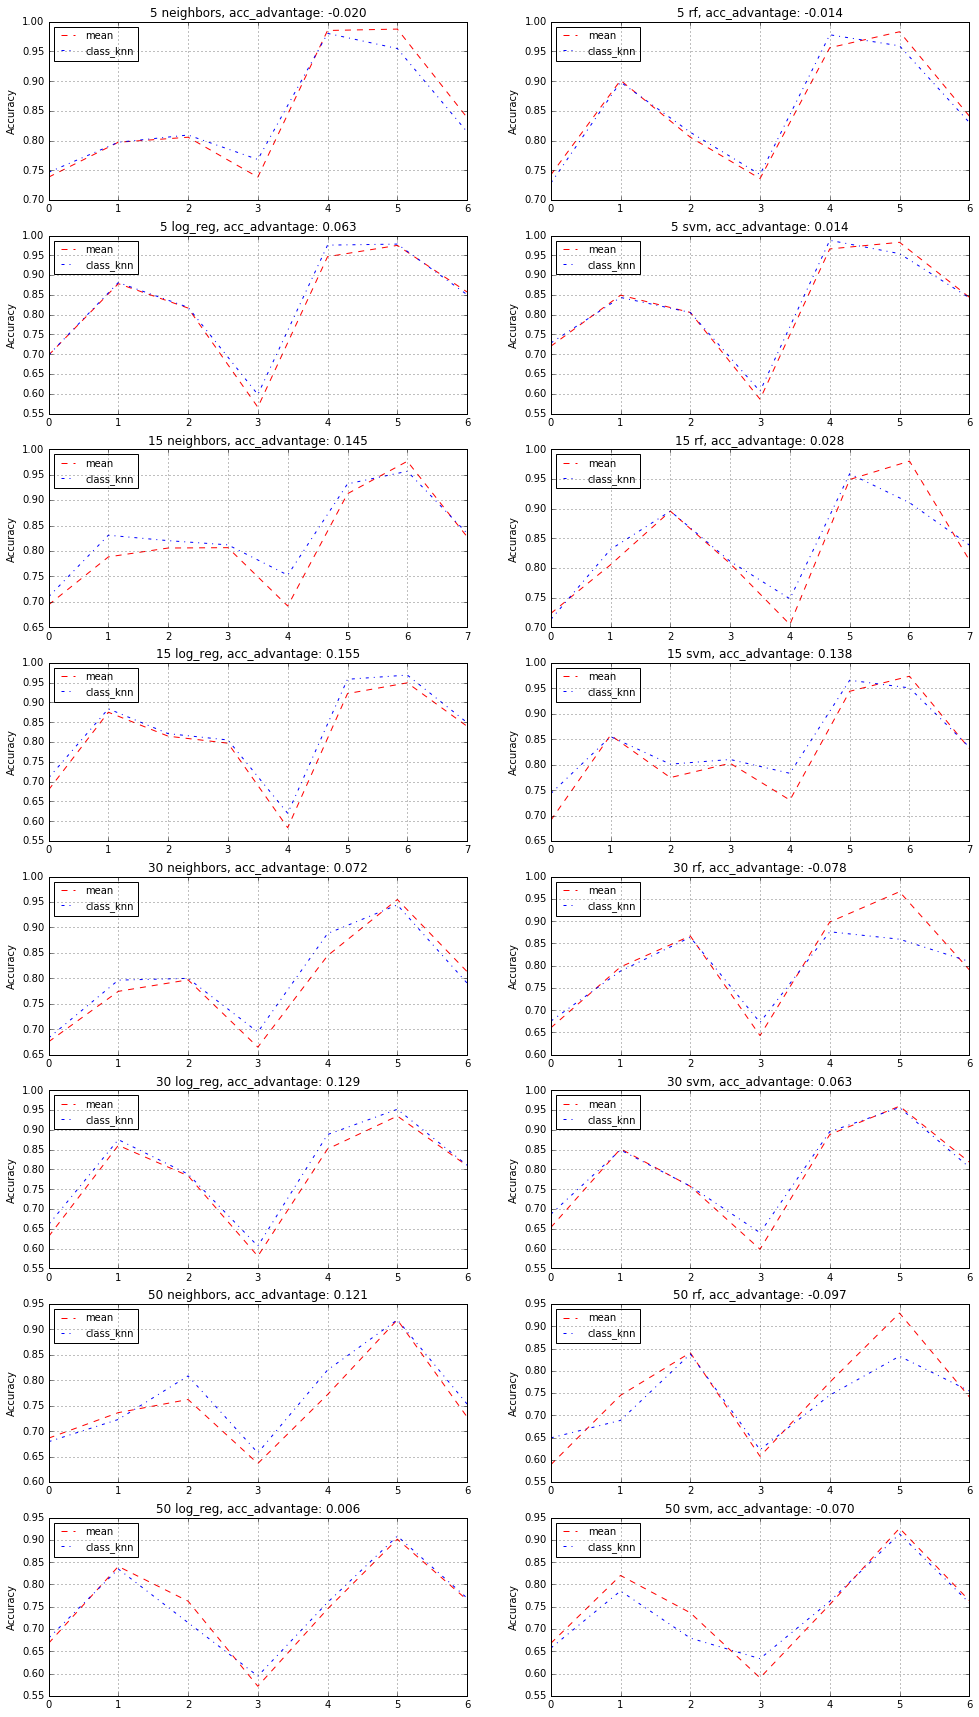

In [13]:
acc_graph('knn+class_knn')

+
+
+
+
+
+
+
+
+
+
+
+


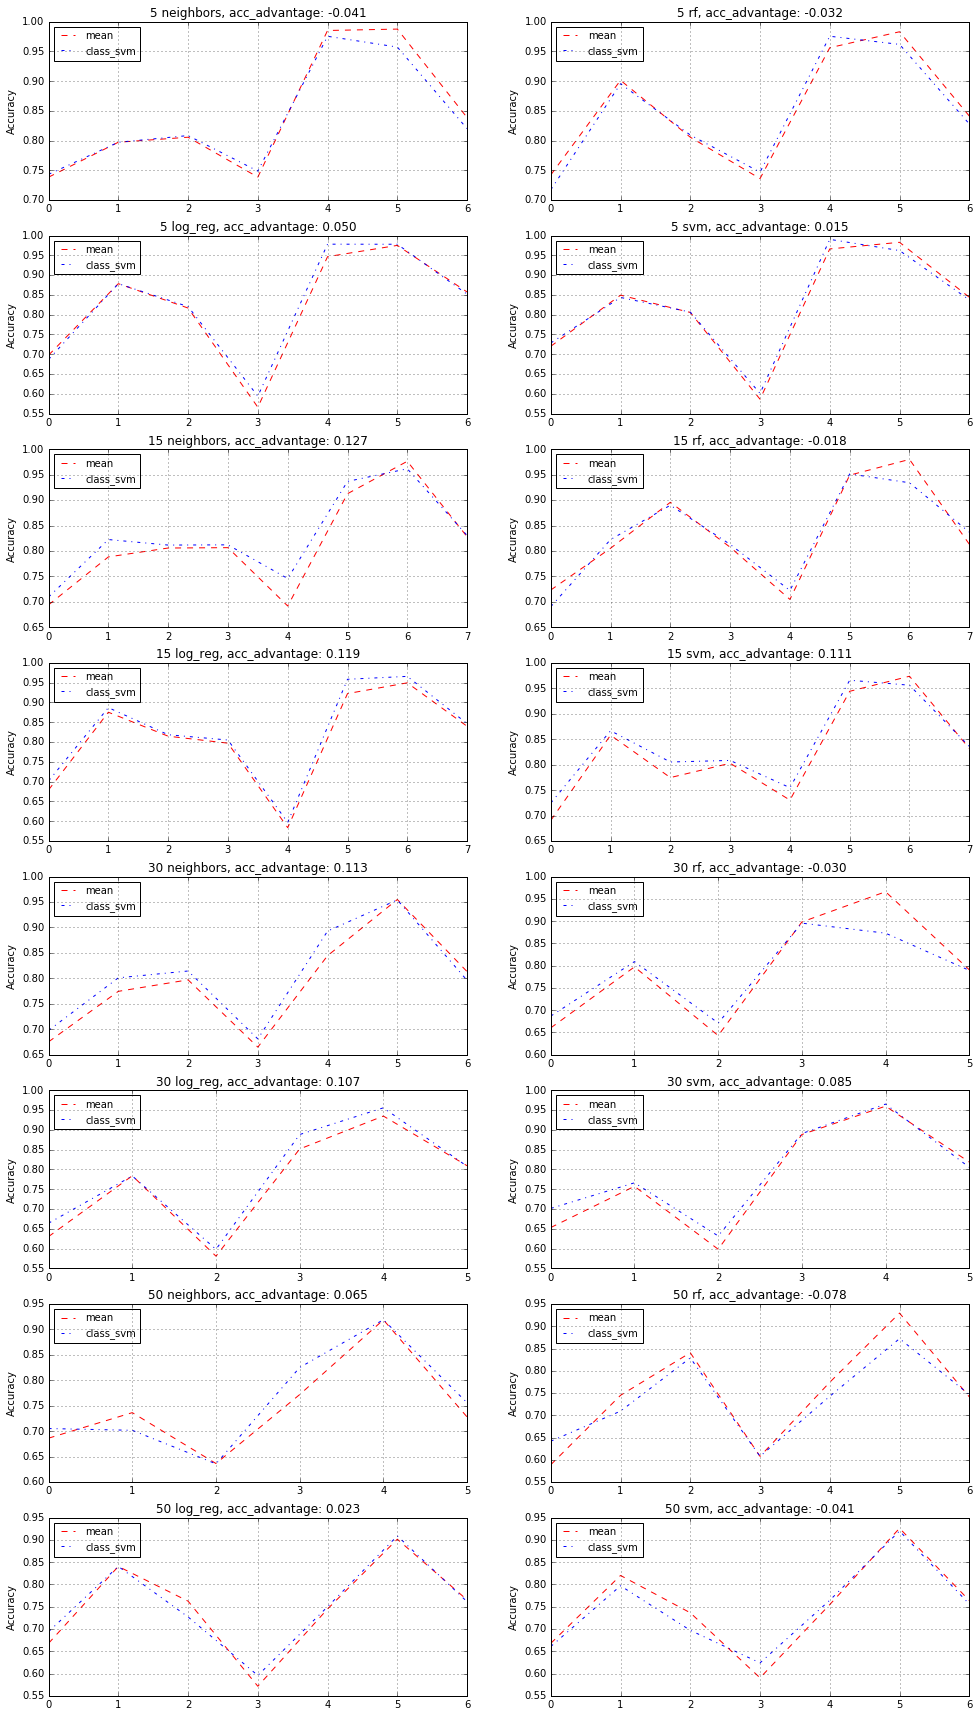

In [14]:
acc_graph('knn+class_svm')

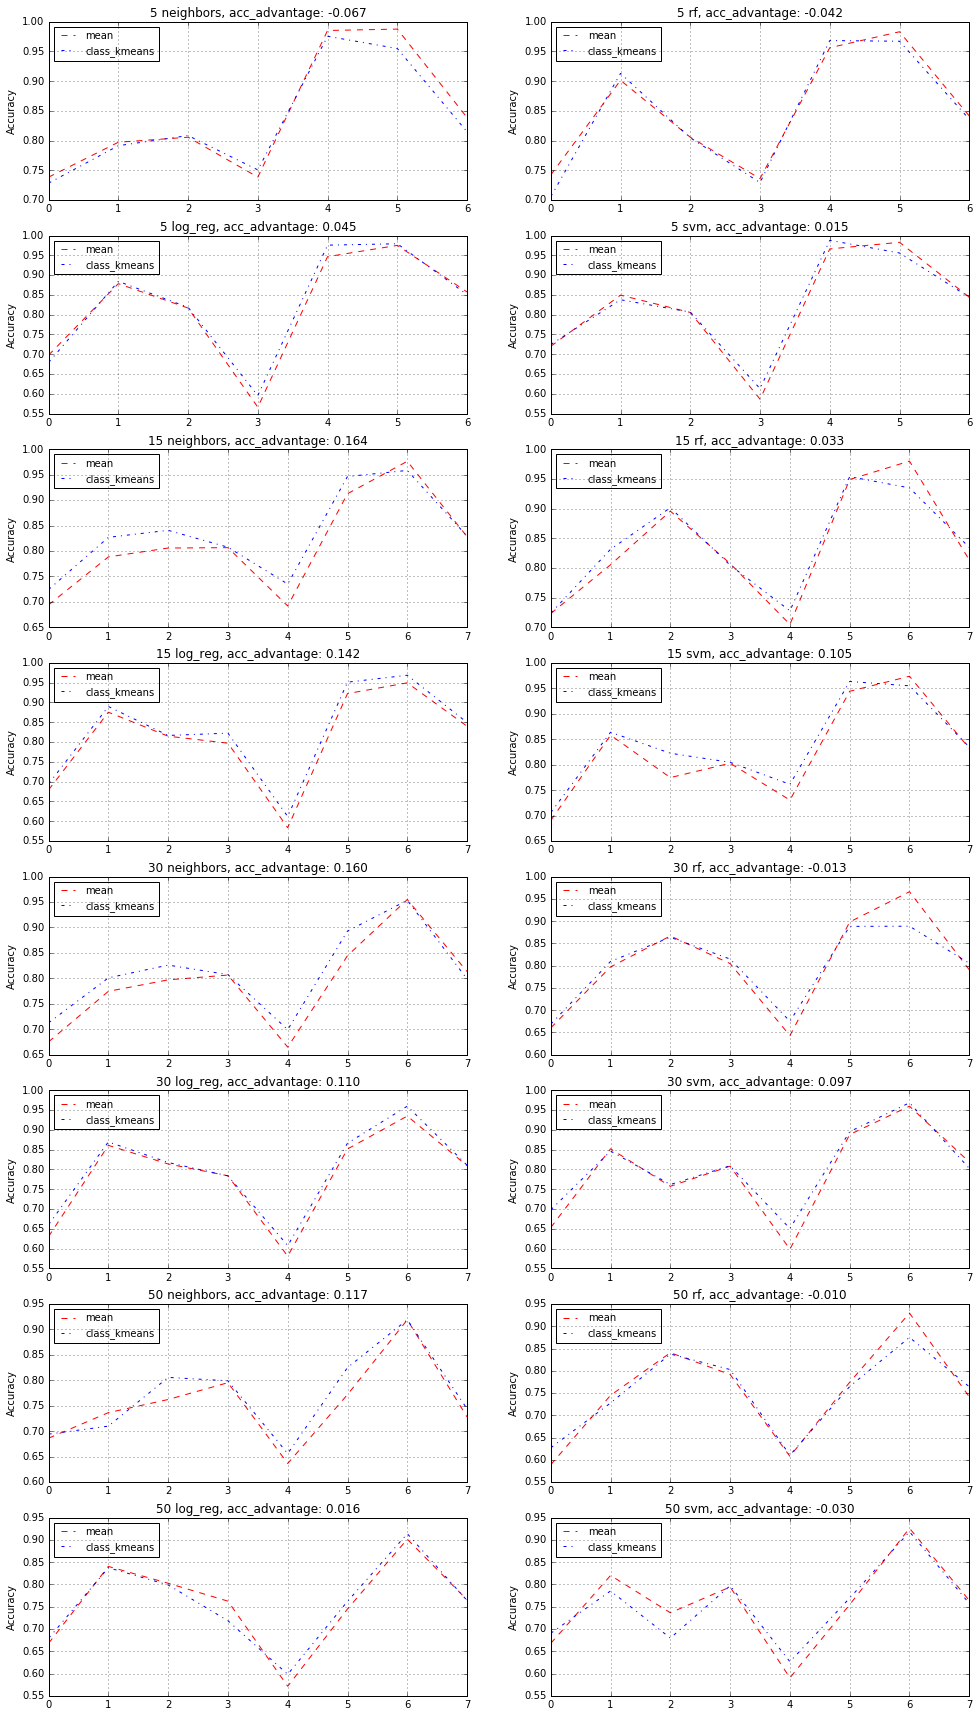

In [15]:
acc_graph('knn+class_kmeans')

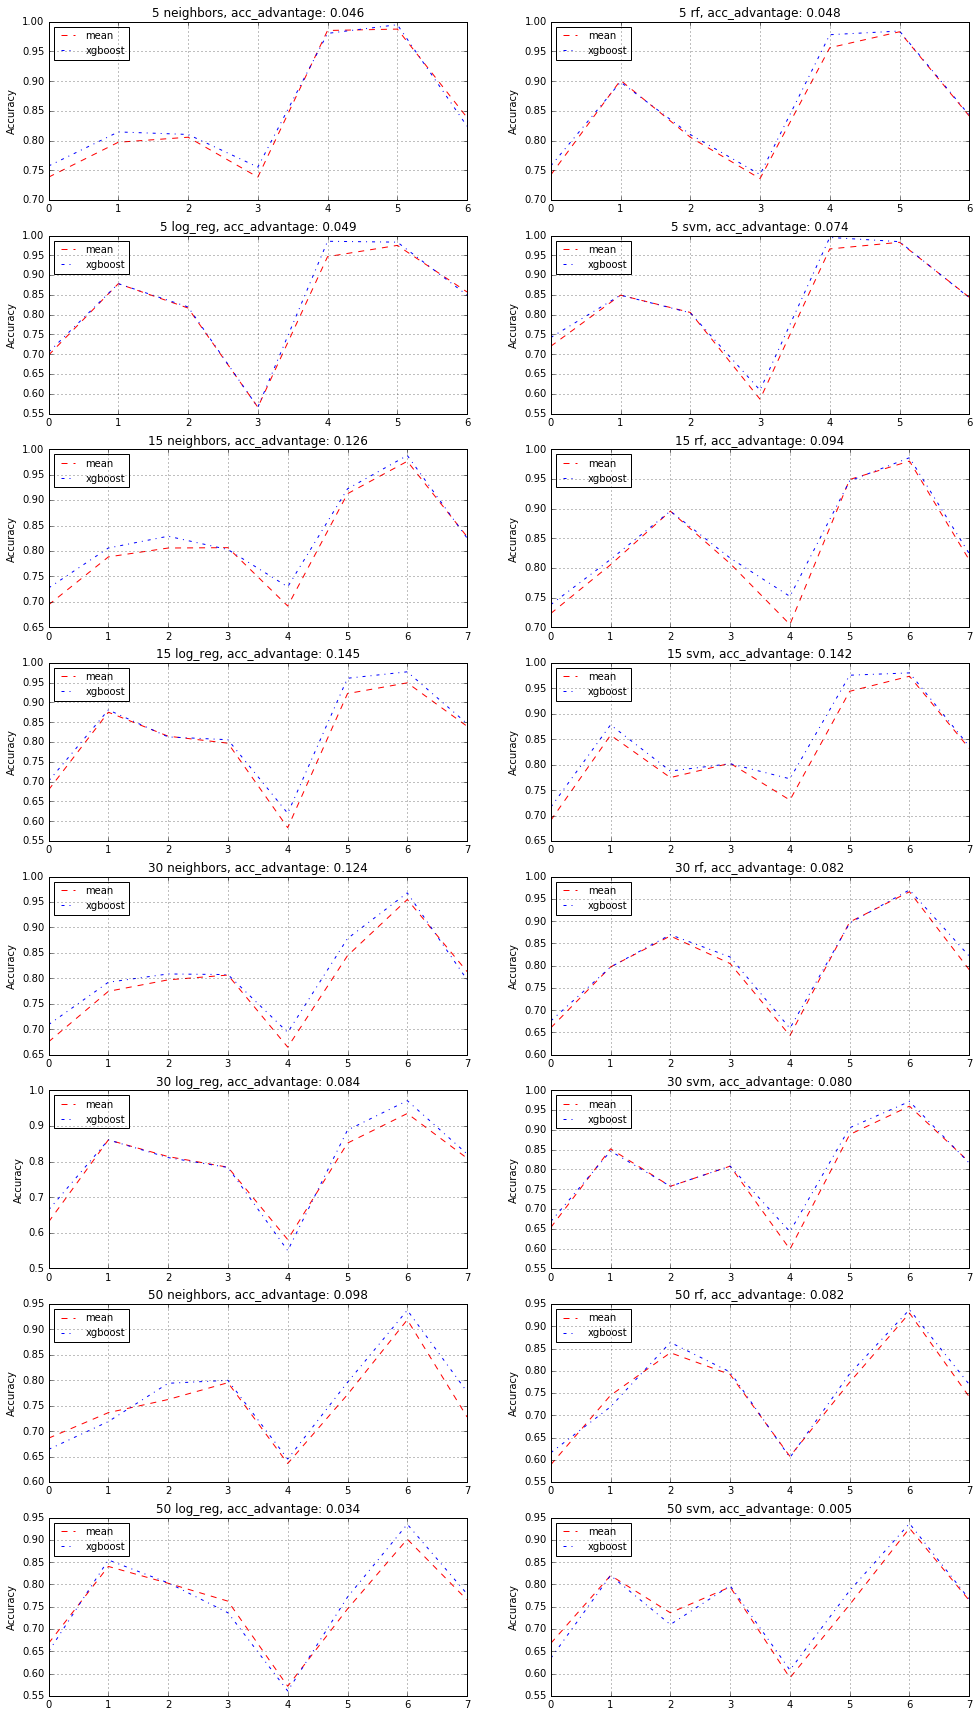

In [16]:
acc_graph('xgboost')

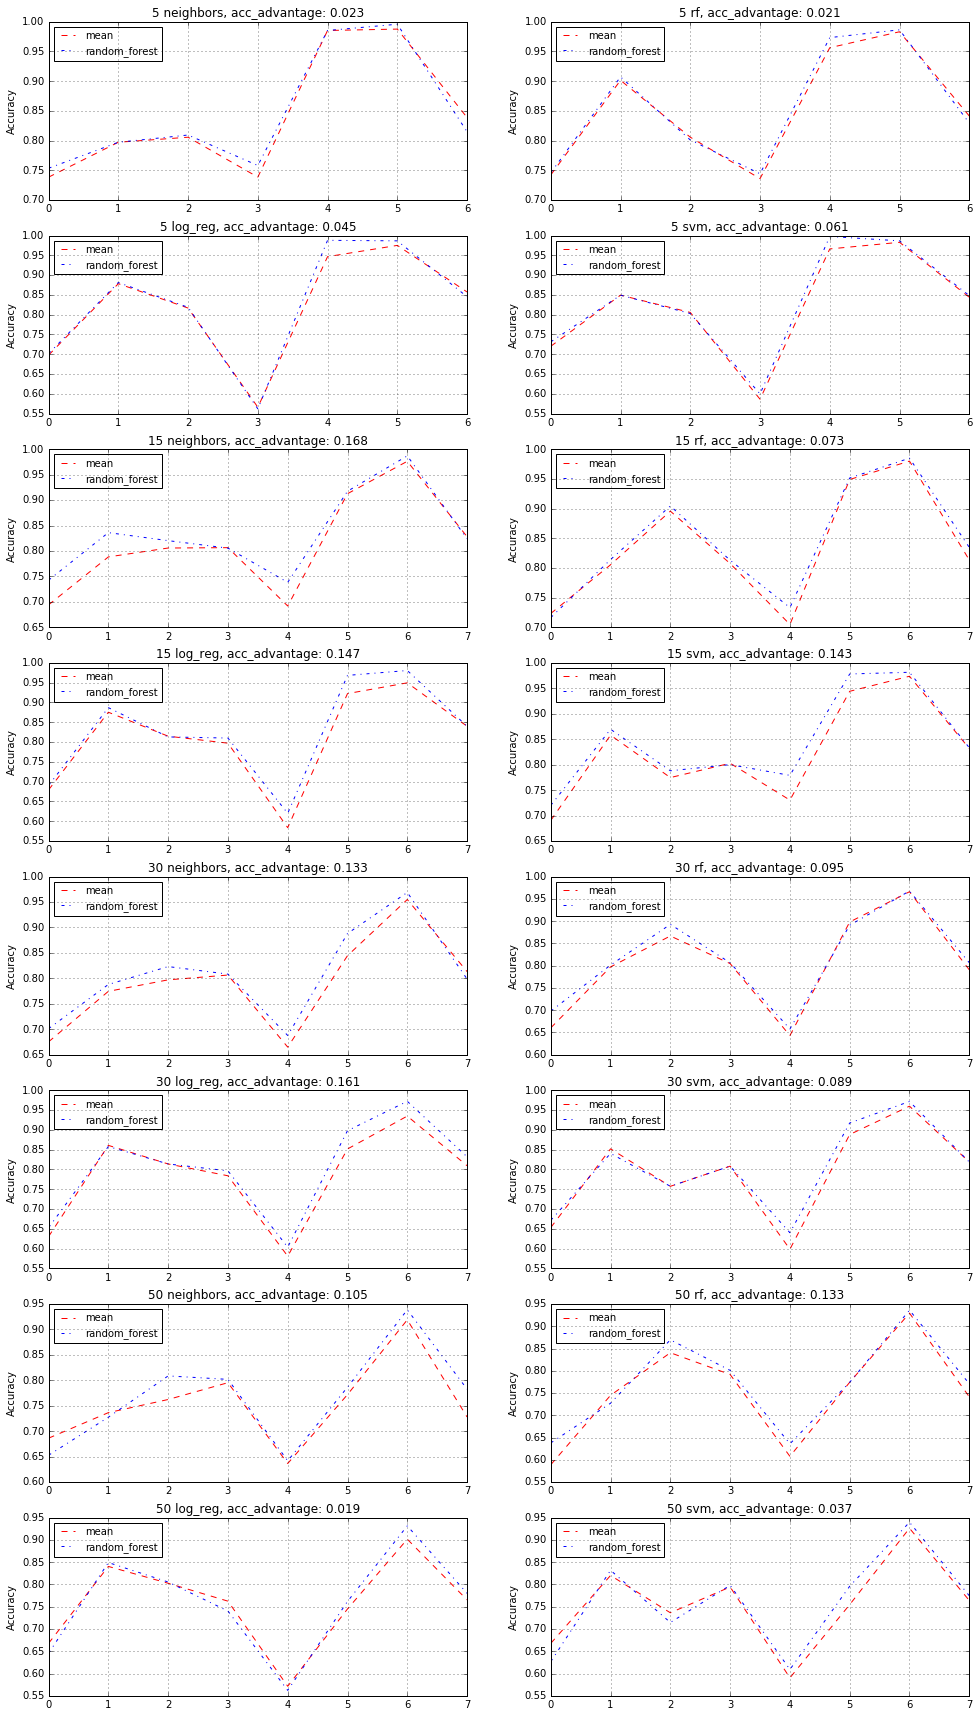

In [17]:
acc_graph('random_forest')

In [18]:
#original func
def get_top_n_dict_rate_with_points(top_n, line, place_counter, n, rate, ml_method, should_process):
    """
    param n: the number of top places we want to account
    param rate: nan values percentage in data we want to account; if < 0 then we account all rates
    param ml_method: machine learning method we want to get statistics for; if None than all methods are acceptable
    """
    parse_result = parse_results_line(line)

    if parse_result is not False:

        flag = parse_result[0]
        info = parse_result[1]

        if flag == 'name':
            place_counter = 1
            if (rate < 0 or info['nan rate'] == rate) and (ml_method is None or info['ml method'] == ml_method):
                should_process = True
            else:
                should_process = False

        if should_process is True and flag == 'result' and place_counter <= n:


            method = info['method']
            points_to_add = n - place_counter + 1

            if method in top_n.keys():
                top_n[method] += points_to_add
            else:
                top_n[method] = points_to_add

            top_n['count'] += 1
            place_counter += 1
            
    return (top_n, place_counter, should_process)